In [1]:
import os
import torch
import pandas as pd
import torch.nn as nn
import numpy as np
from age_prediction.models.\
    efficientnet_pytorch_3d import EfficientNet3D as EfNetB0
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
%matplotlib inline

In [2]:
def MAE_pred(y_pred, y_true):
    mae = nn.L1Loss(reduction='mean')(y_pred, y_true).cpu().detach().numpy().item()
    return mae
def MSE_pred(y_pred, y_true):
    mse = nn.MSELoss()(y_pred, y_true).cpu().detach().numpy().item()
    return mse
def delta_pred(y_pred, y_true):
    delta = y_pred - y_true
    return np.mean(delta)

In [3]:
def ensemble(left, right):
    right = right[['Name', 'Pred']]
    ensemble = pd.merge(left, right, on=['Name'], suffixes=("_L", "_R"))
    ensemble['Pred'] = ensemble.apply(lambda x: (x['Pred_L']+x['Pred_R'])/2, axis=1)
    return ensemble

In [4]:
def metrics(preds):
    print("MAE", MAE_pred(torch.from_numpy(preds['Pred'].values), torch.from_numpy(preds['True'].values)))
    print("MSE", MSE_pred(torch.from_numpy(preds['Pred'].values), torch.from_numpy(preds['True'].values)))
    print("Delta", delta_pred(preds['Pred'], preds['True']))

In [5]:
def plot_regression(x, y):
    slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
    # intercept = 0
    # slope = 1
    line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
    line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
    fig, ax = plt.subplots()
    ax.plot(x, y, linewidth=0, marker='s', label='Data points')
    ax.plot(x, intercept + slope * x, label=line)
    ax.set_xlabel('Chronological age')
    ax.set_ylabel('Estimated age')
    ax.legend(facecolor='white')
    plt.show()

In [6]:
def plot_regression(dt, lim):
    dt = dt[['Name', 'True', 'Pred']]
    dt.columns = ['Image Filename', 'Chronological age', 'Estimated age']

    pearson = pg.corr(dt['Estimated age'], dt['Chronological age'])
    # display(pearson)

    sns.set(style='white', font_scale=1.2)
    g = sns.JointGrid(data=dt, x='Chronological age', y='Estimated age',
                    xlim=lim, ylim=lim, height=5)
    g.plot_joint(sns.regplot, color="xkcd:muted blue")
    g = g.plot_marginals(sns.histplot, color="xkcd:bluey grey")
    g.ax_joint.text(lim[0]+2, lim[1]-2, 'r = ' + str(pearson.r[0].round(2)) + ', p < .001', fontstyle='italic')
    x0, x1 = g.ax_joint.get_xlim()
    y0, y1 = g.ax_joint.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    g.ax_joint.plot(lims, lims, '-r')
    plt.tight_layout()

In [7]:
def bias_corr(pred):
    a = 0.41
    b = 45.42
    return pd.Series((pred - b)/a)

Left
MAE 6.0413254
MSE 73.49619490567329
Delta 0.15555215555555452
Right
MAE 5.274320111111111
MSE 58.776503465509634
Delta -0.5463957111111114
Left+Right
MAE 5.097595844444445
MSE 56.30663739825422
Delta -0.19542177777777858


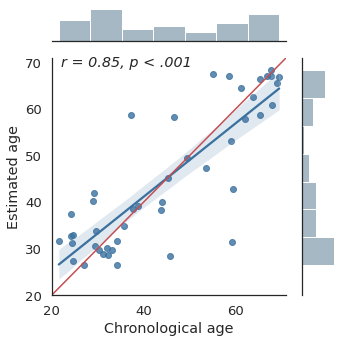

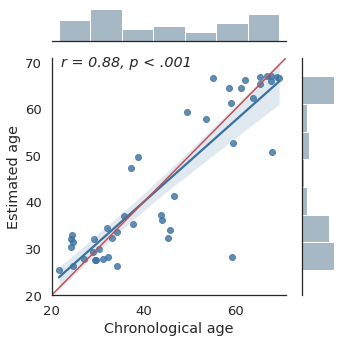

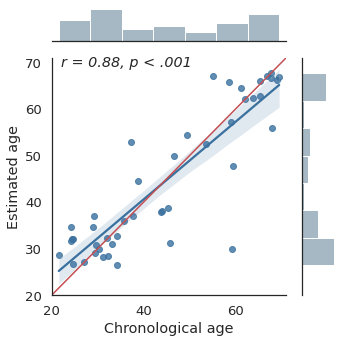

In [8]:
# Validation 0-70
val_L = pd.read_csv("predict_results/val_0-70_L.csv")
val_R = pd.read_csv("predict_results/val_0-70_R.csv")
ens = ensemble(val_L, val_R)
ens.to_csv('predict_results/val_0-70_LR.csv', index=False)
print("Left")
metrics(val_L)
plot_regression(val_L, (20,71))
print("Right")
metrics(val_R)
plot_regression(val_R, (20,71))
print("Left+Right")
metrics(ens)
plot_regression(ens, (20,71))

Left
MAE 4.280906733333333
MSE 41.57018003360079
Delta -0.3980365999999999
Right
MAE 4.317696466666667
MSE 49.035936551256846
Delta -0.7417746888888893
Left+Right
MAE 3.7348223333333337
MSE 37.41828701010571
Delta -0.5699056444444448


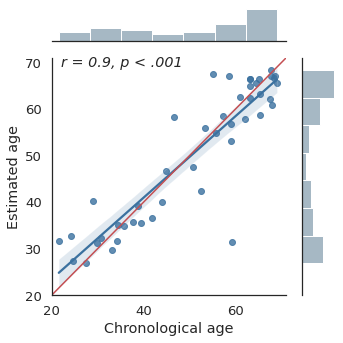

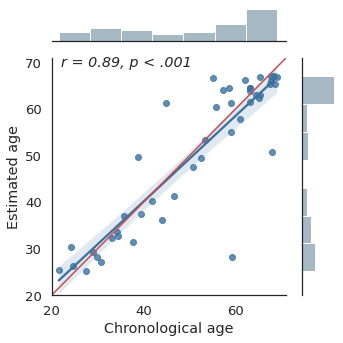

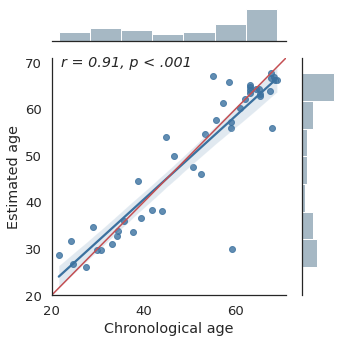

In [9]:
# Test 0-70
val_L = pd.read_csv("predict_results/test_0-70_L.csv")
val_R = pd.read_csv("predict_results/test_0-70_R.csv")
ens = ensemble(val_L, val_R)
ens.to_csv('predict_results/test_0-70_LR.csv', index=False)
print("Left")
metrics(val_L)
plot_regression(val_L, (20,71))
print("Right")
metrics(val_R)
plot_regression(val_R, (20,71))
print("Left+Right")
metrics(ens)
plot_regression(ens, (20,71))

Left
MAE 3.4618065298013247
MSE 17.051834520323677
Delta 0.23183705960264864
Right
MAE 3.588704761589405
MSE 17.660380610909165
Delta 0.2526542980132446
Left+Right
MAE 3.5150833278145694
MSE 17.143837121723855
Delta 0.2422456788079475


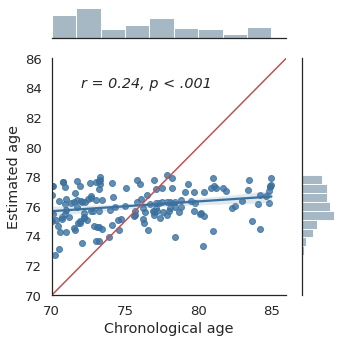

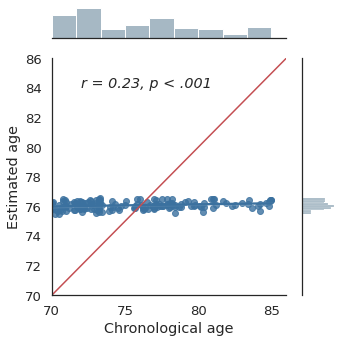

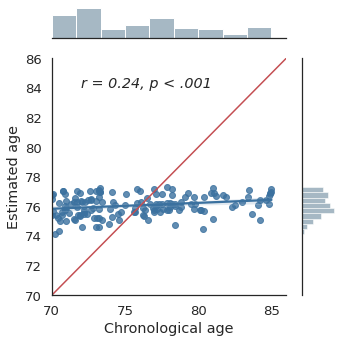

In [10]:
# Val 70-100
left = pd.read_csv("predict_results/val_70-100_L.csv")
right = pd.read_csv("predict_results/val_70-100_R.csv")
ens = ensemble(left, right)
ens.to_csv('predict_results/val_70-100_LR.csv', index=False)
print("Left")
metrics(left)
plot_regression(left, (70,86))
print("Right")
metrics(right)
plot_regression(right, (70,86))
print("Left+Right")
metrics(ens)
plot_regression(ens, (70,86))

Left
MAE 3.3267437483443723
MSE 16.02725981044618
Delta -0.22694119205297972
Right
MAE 3.4872158211920543
MSE 16.74026110065183
Delta 0.1264665761589402
Left+Right
MAE 3.3849480960264904
MSE 16.088173799181156
Delta -0.050237307947019444


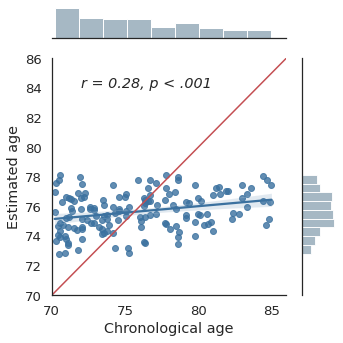

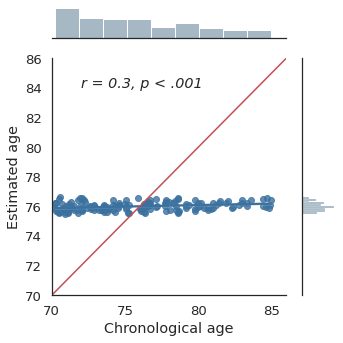

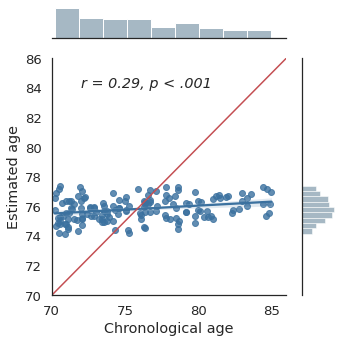

In [11]:
# Test 70-100
left = pd.read_csv("predict_results/test_70-100_L.csv")
right = pd.read_csv("predict_results/test_70-100_R.csv")
ens = ensemble(left, right)
ens.to_csv('predict_results/test_70-100_LR.csv', index=False)
print("Left")
metrics(left)
plot_regression(left, (70,86))
print("Right")
metrics(right)
plot_regression(right, (70,86))
print("Left+Right")
metrics(ens)
plot_regression(ens, (70,86))

Left
MAE 3.707025913875599
MSE 19.038302642054198
Delta -0.6248729856459336
Right
MAE 3.8232527129186606
MSE 19.913529025412714
Delta -0.9160122057416266
Left+Right
MAE 3.7496683564593316
MSE 19.273671079558284
Delta -0.7704425956937806


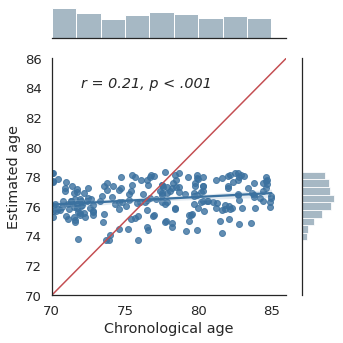

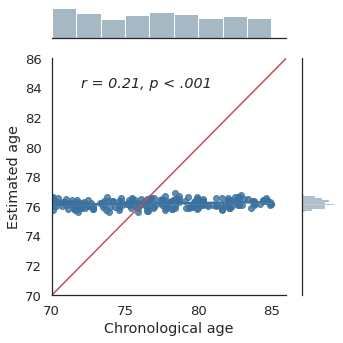

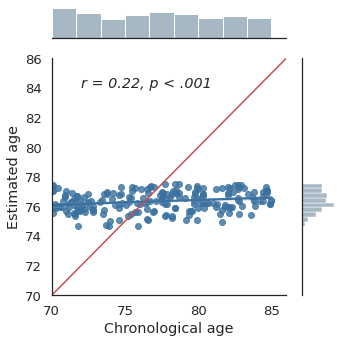

In [14]:
# AD
val_L = pd.read_csv("predict_results/ad_70-100_L.csv")
val_R = pd.read_csv("predict_results/ad_70-100_R.csv")
ens = ensemble(val_L, val_R)
ens.to_csv('predict_results/ad_70-100_LR.csv', index=False)
print("Left")
metrics(val_L)
plot_regression(val_L, (70,86))
print("Right")
metrics(val_R)
plot_regression(val_R, (70,86))
print("Left+Right")
metrics(ens)
plot_regression(ens, (70,86))

Left
MAE 3.6641450239043825
MSE 18.30841897160522
Delta -0.38231353386454214
Right
MAE 3.7033395498007966
MSE 18.55275748661182
Delta -0.626217302788845
Left+Right
MAE 3.671660270916335
MSE 18.26715739321768
Delta -0.5042654183266937


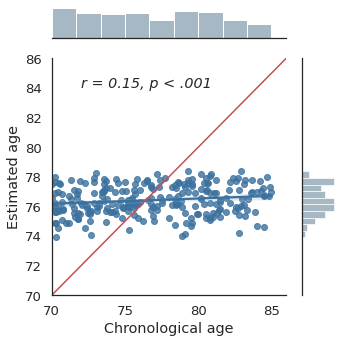

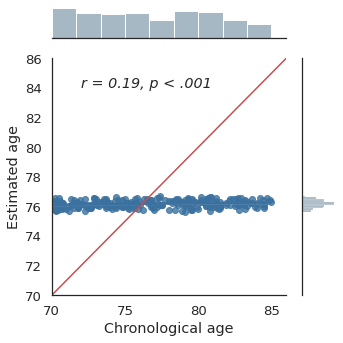

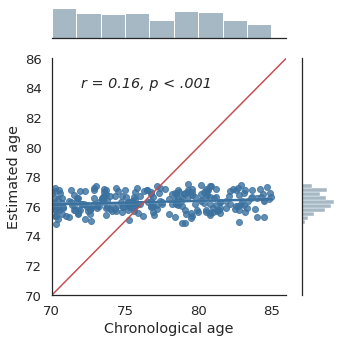

In [15]:
# MCI
val_L = pd.read_csv("predict_results/mci_70-100_L.csv")
val_R = pd.read_csv("predict_results/mci_70-100_R.csv")
ens = ensemble(val_L, val_R)
ens.to_csv('predict_results/mci_70-100_LR.csv', index=False)
print("Left")
metrics(val_L)
plot_regression(val_L, (70,86))
print("Right")
metrics(val_R)
plot_regression(val_R, (70,86))
print("Left+Right")
metrics(ens)
plot_regression(ens, (70,86))